# Coffee Cupping Data Analysis

A recruitment task from https://github.com/polejak/ObjectivityShortDSTask.git

The task is to analyze coffee brewing data. 

Attached document `coffee_data.csv` contains data gathered from cupping sessions which contains such parameters as: 
- brewing time,
- brewing temperature,
- grinding level,
- TDS,
- water pH,
- processing method,
- region and plantation height.

Each coffee was rated from 1-5.
Your task is to tell which parameters affects brewing process the most.

In [10]:
import pandas as pd
import matplotlib
import numpy as np

import qgrid
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, RobustScaler

%matplotlib inline

## A quick look at the data set

The data set contains 2 categorical variables `region` and `processing_method`, one boolean variable `preinfusion`.
The other of variables are numerical.
The marks have values from 1 to 5, with the most common mark being 3 and the least common being 1.
There are 500 samples in the data set.
Three columns have missing data that might interfere with the analysis.

In [44]:
df = pd.read_csv('coffee_data.csv')
qgrid.show_grid(df.head(10))

A Jupyter Widget

In [45]:
pd.DataFrame(df.mark.value_counts()).rename(columns={'mark': 'mark_count'}).sort_index()

,mark_count
1,52
2,99
3,149
4,100
5,100


In [46]:
missing = pd.DataFrame(df.isna().sum(), columns=['missing_value_count'])
missing[missing['missing_value_count']>0]

,missing_value_count
coffee_amount,66
preinfusion,64
TDS,99


## Preprocessing

Preprocessing includes the following steps:
 - filling out missing data
 - replacing categorical data with boolean dummies
 - scaling variables so that they are within the same number range
 
After reviewing the dataset, there seems to be no outliers or incorrect data.
 
### Filling out missing data

It's hard to tell what values should replaced missing data. Having in mind that for some columns as much of 20% of data is missing, samples with missing data cannot be discarded.

For boolean variable `preinfusion`, an acceptable default could be `0`.
For numerical variables `coffee_amount` and `TDS`, which have close to normal distribution, missing data is replaced with the column median. 

After preprocessing all variables are numerical and have values within `<0, 1>` range.

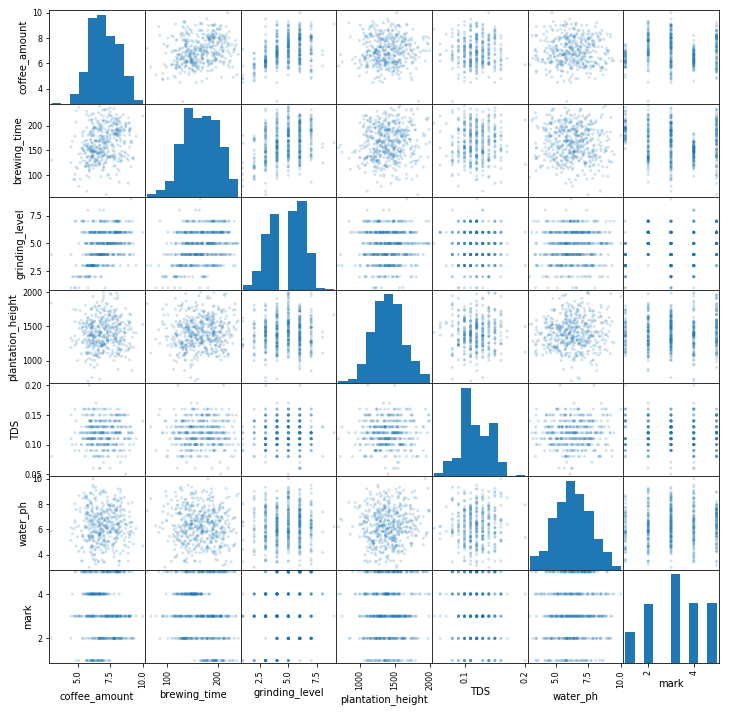

In [71]:
X = df.iloc[:,0:-1]
y = df.iloc[:, -1]
for column in ('region', 'processing_method'):
    X = pd.concat([X, pd.get_dummies(X[column].astype('category'), prefix=column)], axis=1).drop(column, axis=1)

X['preinfusion'] = X['preinfusion'].fillna(0)
for column in ['coffee_amount', 'TDS']:
    X[column] = X[column].fillna(X[column].median())
    
_ = pd.plotting.scatter_matrix(df[[
    'coffee_amount', 'brewing_time', 'grinding_level', 'plantation_height', 'TDS', 'water_ph', 'mark'
]], alpha=0.2, figsize=(12, 12))

In [72]:
scaler = MinMaxScaler()
X_simple = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
qgrid.show_grid(X_simple.head(10))

A Jupyter Widget

## Identifying correlations

To measure the correlation between input variables and the mark, Pearson Correlation Coefficient was calculated.
The coefficient varies between -1 and 1, -1 indicating a negative linear correlation, 1 indicating positive correlation, and 0 no correlation.

Most variables show no correlation with the mark (coefficient in `(-0.05, +0.05)`).
The variables that show some degree of correlation are:
 - `processing_method_Natural` - very weak negative correlation
 - `region_Guatemala`,  `water_ph` - very weak positive correlation
 - `brewing_time` - weak negative correlation
 - `grinding_level` - weak positive correlation

In [75]:
Xy_corr = pd.DataFrame(pd.concat([X_simple, y], axis=1).corr('pearson').drop(['mark']).mark)
top_corr = Xy_corr[Xy_corr['mark'].abs() > 0.05].sort_values('mark')
top_corr

,mark
brewing_time,-0.179540
processing_method_Natural,-0.078965
region_Guatemala,0.064393
water_ph,0.064716
grinding_level,0.164493


In [76]:
lr_simple = LinearRegression()
lr_simple.fit(X_simple, y)
lr_simple.score(X_simple, y)

0.11484762116458769

## Fitting a linear regression model
A linear regression model was fitted to the data to illustrate the impact of input variables on the mark. The fit was plotted along with input data for the correlated columns. 

In [93]:
coeff = pd.DataFrame(lr_simple.coef_, index=X_simple.columns, columns=['coeff'])
coeff.sort_values('coeff')

,coeff
brewing_time,-1.771583
region_Honduras,-0.625485
TDS,-0.450944
region_Kenya,-0.415800
processing_method_Natural,-0.403783
coffee_amount,-0.372868
region_Colombia,-0.304223
region_Rwanda,-0.253698
region_Ethiopia,-0.244773
region_Panama,-0.211990


In [85]:
N = 50
points_x = pd.DataFrame(np.linspace(-0.5, 1.5, N).reshape(N, 1) * np.ones((N, X_simple.shape[1])), columns=X_simple.columns)
points_y = pd.DataFrame(np.zeros((N, X_simple.shape[1])), columns=X_simple.columns)
for column in points_y.columns:
    points_y[column] = (points_x[column] * coeff.loc[column].values[0]) + lr_simple.intercept_
points_x = pd.DataFrame(scaler.inverse_transform(points_x), columns=X_simple.columns)

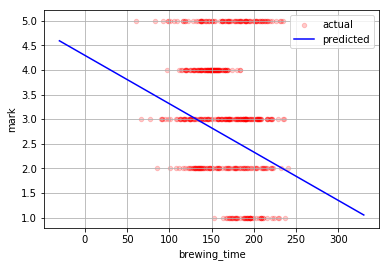

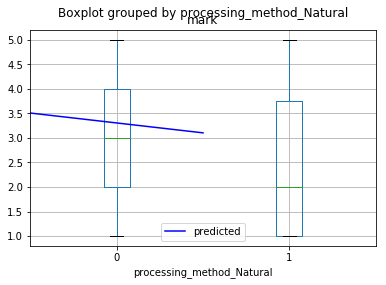

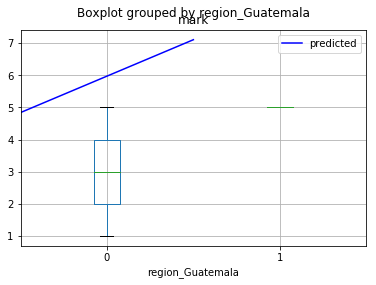

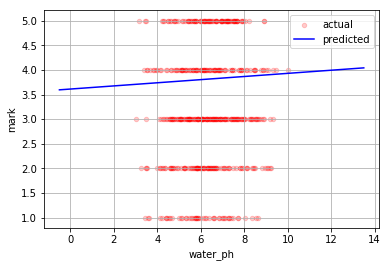

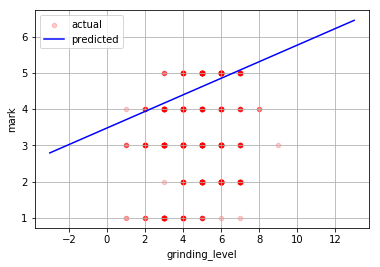

In [94]:
for column in top_corr.index:
    if X.dtypes[column] == np.dtype('uint8'):
        ax1 = pd.DataFrame({column: X[column], 'mark': y}).boxplot(column='mark', by=column, grid=True)
    else:
        ax1 = pd.DataFrame({column: X[column], 'mark': y}).plot(kind='scatter', alpha=0.2, x=column, y='mark', grid=True, color='red', label='actual')
    try:
        ax2 = pd.DataFrame({column: points_x[column], 'mark_pred': points_y[column]}).plot(ax=ax1, kind='line', x=column, y='mark_pred', color='blue', grid=True, label='predicted')
    except Exception:
        pass

A scatter plot of an uncorrelated variable

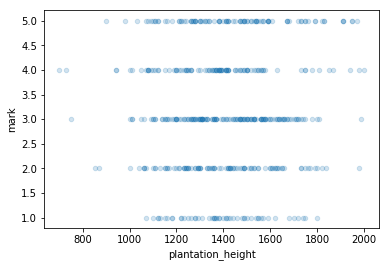

In [96]:
_ = df[['plantation_height', 'mark']].plot(x='plantation_height', alpha=0.2, y='mark', kind='scatter')

# Conclusions
The analysis discovered weak or no impact between the input variables and the mark. There may be some factors that are not included in the dataset, but may greatly influence the mark like:
* the taster's preferences - there could have been many tasters
* coffee bean quality
* roast type - light, medium, dark
* brew preparation method
* single origin or blend
* missing data

As the relationship between variables is noisy and not strictly linear, the linear regression model didn't fit the data well. A more sophisticated regression model could be fitted to the data - for example Support Vector Machines.

Based on the simple analysis, the most important factors for the brew mark are **brewing time** and **grinding level**. Longer brewing time has a negative effect on the mark, while a higher grinding level has a positive effect on the mark.

## End notes
This solution was prepared with Python 3.5.0 and the following packages

```
jupyter==1.0.0
matplotlib==2.2.3
numpy==1.15.0
pandas==0.23.4
scikit-learn==0.19.1
qgrid==1.1.1
```